### Untersuchung die Konvergenz und Entwicklung der Dichtefunktionen des Kalman Filters 

In [1]:
using Distributions, Compat, Plots, Random
gr()
upscale = 1
Plots.scalefontsizes(1.65)
default(line = (0.5, 1, 2), size=(800*upscale,600*upscale))
default(dpi = 100)
# default(dpi = 350)

In [2]:
include("../KalmanFilter.jl")

Main.KalmanFilter

Wir erstellen ein Experiment. Eine Spannungsquelle hat den konstanten, dem Beobachter nicht bekanntem Wert von $U = 10$. Da dem Beobacher bekannt ist, dass sich die Spannung mit der Zeit nicht ändert, wird ein lineartes Modell erstellt.

Die Messungen erfolgen mit einem Grad an ungenauigkeit. Das simulieren wir durch das hinzufügen von normalverteiltes Rauschen.

In [3]:
range = 5:0.05:12
ρ = 10 # Die Spannung, die wir messen ist immer konstant

A = 1
Q = 0.9

G = 1
R = 0.8

x_0 = 8
Σ_0 = 1 

model = KalmanFilter.Kalman(A, Q, G, R, x_0, Σ_0)

y = () -> G * ρ + rand(Normal(0, 0.5)) # Messfunktion

#3 (generic function with 1 method)

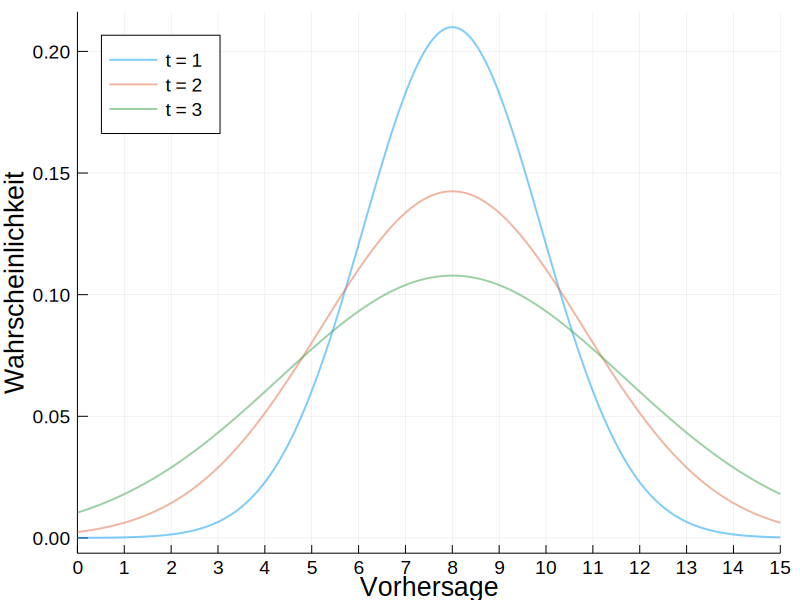

In [4]:
range = 0:0.05:15
p = plot(xlabel = "Vorhersage", ylabel = "Wahrscheinlichkeit", legend = :topleft, color = :blue, xlim = (0, 15), xticks = 0:15)
for i = 1:3
    tmp = KalmanFilter.predict(model)
    plot!(range, pdf.(Normal(tmp.state, tmp.cov), range), label = "t = $i")
end
png("prediction-only.png")
p

Man sieht: Wie in unserem Modell definiert, das Maximum der Verteilungen ist immer 8. Gleichzeitig wird die Varianz ständig größer.
Daher werden nun Messungen berücksichtigt:

In [5]:
p_0 = Normal(x_0, Σ_0) # Start period with p_t(x) = N(x̂_t, Σ_t)
y_0 = y() # Observe measurement y_t

# Compute filtering distribution p(x|y) = N(x̂_0_F, Σ_0_F)
tmp = KalmanFilter.fusion(model, y_0)
p_0_f = Normal(tmp.state, tmp.cov)

# Compute predictive distribution
tmp = KalmanFilter.predict(model)
p_1 = Normal(tmp.state, tmp.cov)

tmp = KalmanFilter.fusion(model, y())
p_1_f = Normal(tmp.state, tmp.cov)

# Compute predictive distribution
tmp = KalmanFilter.predict(model)
p_2 = Normal(tmp.state, tmp.cov)

tmp = KalmanFilter.fusion(model, y())
p_2_f = Normal(tmp.state, tmp.cov)

tmp = KalmanFilter.predict(model)
p_3 = Normal(tmp.state, tmp.cov)

tmp = KalmanFilter.fusion(model, y())
p_3_f = Normal(tmp.state, tmp.cov)


BoundsError: BoundsError: attempt to access ()
  at index [1]

In [6]:
range = 5:0.05:12
p = plot(range, pdf.(p_0, range), label = "t = 0", xlabel = "Messwert/Schätzung", ylabel = "Wahrscheinlichkeit", legend = :topleft, color = :blue)
plot!(range, pdf.(p_0_f, range), label = "t = 0 Gefiltert", linestyle = :dash, color = :blue)

plot!(range, pdf.(p_1, range), label = "t = 1", color = :green)
plot!(range, pdf.(p_1_f, range), label = "t = 1 Gefiltert", linestyle = :dash, color = :green)

plot!(range, pdf.(p_2, range), label = "t = 2", color = :red)
plot!(range, pdf.(p_2_f, range), label = "t = 2 Gefiltert", linestyle = :dash, color = :red)

plot!(range, pdf.(p_3, range), label = "t = 3", color = :black)
plot!(range, pdf.(p_3_f, range), label = "t = 3 Gefiltert", linestyle = :dash, color = :black)

png("stochastic-mass.png")
p

UndefVarError: UndefVarError: p_0_f not defined

Die gestrichelte Linien stellen immer den Zustand nach dem Filterung dar, d.h. hier wurden die Messwerte schon berücksichtight. Es ist eindeutig zu erkennen, dass die Vorhersagen sich nach den gesetzen des Modells verhalten, aber durch die Messung wird sowohl die Varianz als auch die Erwartungswert korrigiert.